# Making Business Decisions Based on Data project
by Michael Birman

##  Prioritizing Hypotheses
The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.
The task is to:
* Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
* Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
* Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

## A/B Test Analysis
You carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv.
Task
Analyze the A/B test:
1. Graph cumulative revenue by group. Make conclusions and conjectures.
2. Graph cumulative average order size by group. Make conclusions and conjectures.
3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.
4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.
6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
7. Plot a scatter chart of order prices. Make conclusions and conjectures.
8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.
10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.
11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.
12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.
13. Make a decision based on the test results. The possible decisions are: 
* Stop the test, consider one of the groups the leader. 
* Stop the test, conclude that there is no difference between the groups. 
* Continue the test.

In [1]:
import pandas as pd
import statistics
import datetime as dt
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats as st

from pandas.plotting import scatter_matrix

import seaborn as sns
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
from IPython.display import Image
from IPython.core.display import HTML 



In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep = ";", dtype = {'Hypothesis' : 'category'})
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates = ['date'])
visits = pd.read_csv('/datasets/visits_us.csv', parse_dates = ['date'])

In [3]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
hypotheses.columns = hypotheses.columns.str.lower()



print('visits')
visits.info(memory_usage='deep')
visits.head()
visits.describe()
print()
print('orders')
orders.info(memory_usage='deep')
orders.head()
orders.describe()
print()
print('hypotheses')
hypotheses.info(memory_usage='deep')
hypotheses.head()
hypotheses.describe()



visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB

hypotheses
<class 'pandas.core.frame.DataFrame'>


,reach,impact,confidence,effort
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [4]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
hypotheses.head()

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


-  deliting visitors abserved in both groups

In [7]:
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')
both_groups = pd.merge(orders_a, orders_b, how='inner', on= ['visitorid'])
print('Number of users that we can observe in both groups:', pd.Series(len(both_groups)))


bad_list = both_groups['visitorid']
bad_list

Number of users that we can observe in both groups: 0    183
dtype: int64


0      4069496402
1       199603092
2       199603092
3       199603092
4       199603092
          ...    
178    4186807279
179    4186807279
180    2712142231
181    2949041841
182     963407295
Name: visitorid, Length: 183, dtype: int64

In [8]:
both_groups.sample()

,transactionid_x,visitorid,date_x,revenue_x,group_x,transactionid_y,date_y,revenue_y,group_y
166,2316868256,2600415354,2019-08-31,45.9,A,1954636284,2019-08-06,25.5,B


183 users who are in both groups. this is not much, we can get rid of them for our future calculations.

In [9]:
full_orders = orders.copy()
orders = orders[~orders['visitorid'].isin(bad_list)]
orders.info()
full_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object 

In [10]:
# cheking visits
visits = visits.drop_duplicates()
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ KB


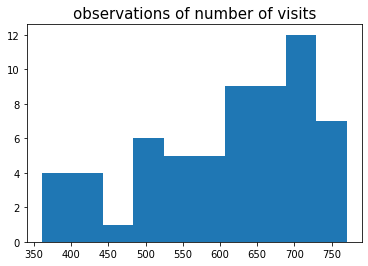

In [11]:
plt.hist(visits['visits'])
plt.title('observations of number of visits', fontsize = 15)

plt.show()

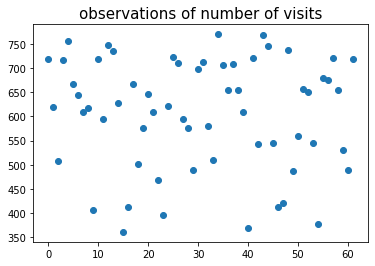

In [12]:
x_values = pd.Series(range(0, len(visits['visits'])))
plt.scatter(x_values, visits['visits'])
plt.title('observations of number of visits', fontsize = 15)
plt.show()

looks like a normal distribution with no outliers
Let's look at the percentage.

In [13]:

print('percentiles: 90%, 95%, 99%:', np.percentile(visits['visits'], [90, 95, 99]))

percentiles: 90%, 95%, 99%: [733.7  747.9  769.39]


the same picture. only one percent more than 769 and 90 percent less than 733

let's chek the dates with 2 or more observations.

In [14]:
visits['date'].value_counts()
len(visits['date'].value_counts())


31

31, like expected 

#  Prioritizing Hypotheses

* Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
* Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

In [15]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [16]:
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
hypotheses = hypotheses.sort_values('ICE', ascending=False )
hypotheses

,hypothesis,reach,impact,confidence,effort,ICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000


* Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority

In [17]:
hypotheses['RICE'] = (hypotheses['impact'] * hypotheses['confidence'] * hypotheses['reach']) / hypotheses['effort']
hypotheses = hypotheses.sort_values('RICE', ascending=False )
hypotheses

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


*  the entire order change when using RISE instant of ICE because we use more variables in our calculations
* we can see that the top 5 stays top 5 in both orders and bottom 5 stays in bottom 5, exept the hypothes 4, that stay on the bottom on both orders, so it'll be the kast one to chek.
* we will use the RICE one as apriopitizer, its more accurate


 # A/B Test Analysis

# 1. Graph cumulative revenue by group. Make conclusions and conjectures.

In [18]:
revenue_by_group = pd.pivot_table(orders, values = 'revenue', index = 'date', columns = 'group', aggfunc=np.sum)
camulative_revenue_by_group = revenue_by_group.cumsum()
camulative_revenue_by_group.sample()


group,A,B
date,,
2019-08-10,16121.5,20103.6


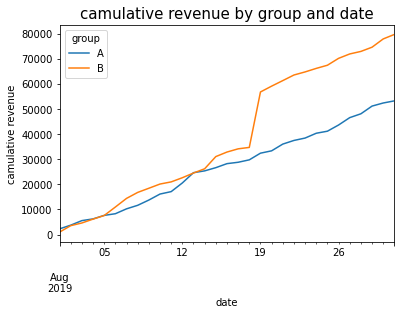

In [19]:
camulative_revenue_by_group.plot()
plt.title('camulative revenue by group and date', fontsize = 15)
plt.xlabel('date')
plt.ylabel('camulative revenue')
plt.show()
camulative_revenue_by_group = pd.DataFrame(camulative_revenue_by_group.to_records())

* as we can see the metric of group a is lower than group b duering all the test, exept one point on 13-th day of the test
* we can see that graph is stabilized toward the half of the test
* revenue of group b is better during the whole test but we see that there is a big pick on 19 -th day of the test maby the reason is very expencive orders. we will chek it later.

another way to check and prepare an additional parameter for further calculations

In [20]:
dates_groups = orders[['date','group']].drop_duplicates()
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visits_aggregated = dates_groups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulative_data = orders_aggregated.merge(visits_aggregated,left_on=['date','group'], right_on=['date','group'])
cumulative_data.columns = ['date', 'group', 'orders', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,revenue,visitors
0,2019-08-01,A,23,2266.6,719
1,2019-08-01,B,17,967.2,713
2,2019-08-02,A,42,3734.9,1338
3,2019-08-02,B,40,3535.3,1294
4,2019-08-03,A,66,5550.1,1845


In [21]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

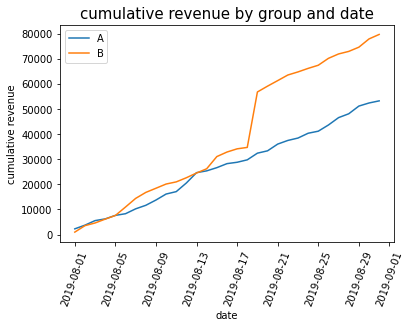

In [22]:
plt.plot(cumulative_revenue_a['date'],cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'],cumulative_revenue_b['revenue'], label='B')
plt.xticks(rotation=70)
plt.title('cumulative revenue by group and date', fontsize=15)
plt.xlabel('date')
plt.ylabel('cumulative revenue')
plt.legend()
plt.show()


the same graph and the same conclusions

# 2. Graph cumulative average order size by group. Make conclusions and conjectures.

In [23]:
average_order_size_by_group = pd.pivot_table(orders, values='revenue', index='date', columns='group', aggfunc=np.average)
average_order_size_by_group.sample()

group,A,B
date,,
2019-08-25,102.275,104.608333


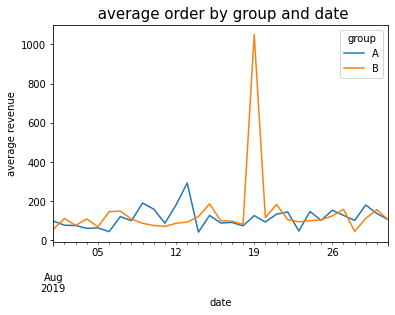

In [24]:
average_order_size_by_group.plot()
plt.title(' average order by group and date', fontsize = 15)
plt.xlabel('date')
plt.ylabel('average revenue')
plt.show()

as in the previous graph, we see a small peak in group a on day 13 of the test and a huge peak in group b on day 19 of the test.
it can be assumed, that:
1. group b gives the best performance
2. perhaps the best performance of group b due to abnormally expensive orders. we will check it out.

In [25]:
cumulative_average_order_size_by_group = average_order_size_by_group.cumsum()

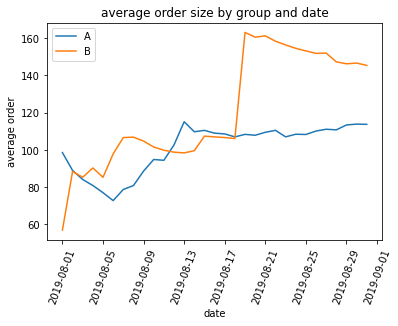

In [26]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.xticks(rotation=70)
plt.legend()
plt.title('average order size by group and date')
plt.xlabel('date')
plt.ylabel('average order')
plt.xticks(rotation=70)
plt.show()

the graph of cumulative orders shows that our conclusions are correct. here, too, there is a large peak on August 19 for group B and a small peak of 13 for group A. in any case, we need to continue the test

# 3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

In [27]:
cumulative_average_order_size_by_group =  pd.DataFrame(cumulative_average_order_size_by_group.to_records())
cumulative_average_order_size_by_group.head()

,date,A,B
0,2019-08-01,98.547826,56.894118
1,2019-08-02,175.826773,168.550639
2,2019-08-03,251.460107,245.093497
3,2019-08-04,312.869198,354.493497
4,2019-08-05,376.414652,423.507782


In [28]:
cumulative_average_order_size_by_group['differ'] = cumulative_average_order_size_by_group['B'] - cumulative_average_order_size_by_group['A']
cumulative_average_order_size_by_group.head()

,date,A,B,differ
0,2019-08-01,98.547826,56.894118,-41.653708
1,2019-08-02,175.826773,168.550639,-7.276134
2,2019-08-03,251.460107,245.093497,-6.366610
3,2019-08-04,312.869198,354.493497,41.624299
4,2019-08-05,376.414652,423.507782,47.093130


I prefer to leave these values and not convert them to absolute. It is important for me to know when which group is leading, and if the values ​​are absolute, I can lose these changes

In [29]:
differece_by_date = cumulative_average_order_size_by_group.drop(['A','B'], axis=1)
differece_by_date_cum_sum = differece_by_date['differ'].cumsum()
differece_by_date_cum_sum.head()

0   -41.653708
1   -48.929843
2   -55.296453
3   -13.672154
4    33.420976
Name: differ, dtype: float64

In [30]:
number_orders_by_group = pd.pivot_table(orders, values='transactionid', index='date', columns='group', aggfunc= lambda x: len(x.unique()))
number_orders_by_group = pd.DataFrame(number_orders_by_group.to_records())
number_orders_by_group.head()

,date,A,B
0,2019-08-01,23,17
1,2019-08-02,19,23
2,2019-08-03,24,14
3,2019-08-04,11,14
4,2019-08-05,22,21


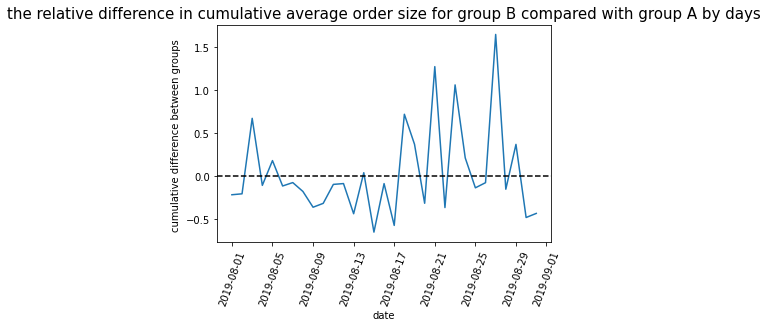

In [31]:
plt.plot(differece_by_date['date'],(cumulative_average_order_size_by_group['B'] / number_orders_by_group['B'])/(cumulative_average_order_size_by_group['A'] / number_orders_by_group['A']) - 1)
plt.title('the relative difference in cumulative average order size for group B compared with group A by days', fontsize=15)
plt.xlabel('date')
plt.ylabel('cumulative difference between groups ')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=70)
plt.show()

we see quite a few peaks in the difference between the groups. and one big spike on day 19, possibly due to outliers (abnormally large orders in Group B).
At the same time, group B gives the best results throughout the test.

# 4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

In [32]:
number_visits_by_group = pd.pivot_table(visits, values='visits', index='date', columns='group', aggfunc= np.sum)
number_visits_by_group = pd.DataFrame(number_visits_by_group.to_records())
number_visits_by_group.head()

,date,A,B
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707


In [58]:
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [33]:
conversion_a = number_orders_by_group['A'] / number_visits_by_group['A']
conversion_b = number_orders_by_group['B'] / number_visits_by_group['B']
dates = number_orders_by_group['date']


In [34]:
conversion_a.head()

0    0.031989
1    0.030695
2    0.047337
3    0.015342
4    0.029101
Name: A, dtype: float64

In [35]:
conversion_b.head()

0    0.023843
1    0.039587
2    0.027505
3    0.018182
4    0.029703
Name: B, dtype: float64

In [36]:
statistics.mean(conversion_a)

0.025890306958716497

In [37]:
statistics.mean(conversion_b)

0.03042400280520272

Group B's conversion is slightly higher than Group A's, but only by half a percent. while the entire conversion of group B is 3 percent, so the difference may be noticeable in this case.

let's check that with cumulative conversion for both groups.

In [38]:
conversion_a_cum = conversion_a.cumsum()
conversion_b_cum = conversion_b.cumsum()

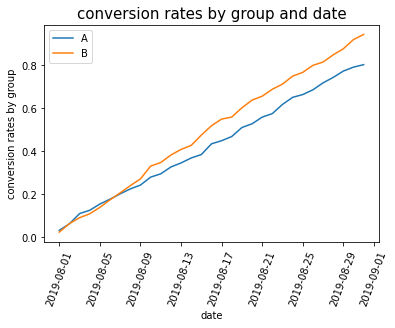

In [39]:
plt.plot(dates, conversion_a_cum, label='A')
plt.plot(dates, conversion_b_cum, label='B')
plt.legend()
plt.title('conversion rates by group and date', fontsize=15)
plt.xlabel('date')
plt.ylabel('conversion rates by group')
plt.xticks(rotation=70)
plt.show()


and here too. at the very beginning, group A is slightly higher than group B, but already less than a third from the test, group B takes the lead.

# 5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [40]:
orders_by_user = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index =False).agg({'transactionid' : pd.Series.nunique})
orders_by_user.columns = ['visitor_id', 'orders']
orders_by_user.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


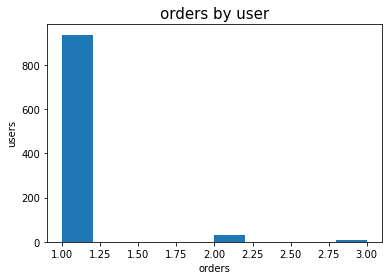

In [41]:
# plot histogramm 
plt.hist(orders_by_user['orders'])
plt.title('orders by user', fontsize=15)
plt.xlabel('orders')
plt.ylabel('users')
plt.show()

strange values at 2.00 and 2.75. possible outliers. check on the scutterplot


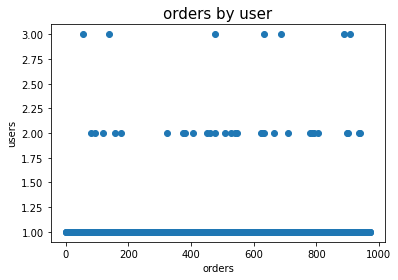

In [42]:
x_values = pd.Series(range(0, len(orders_by_user)))
plt.scatter(x_values, orders_by_user['orders'])
plt.title('orders by user', fontsize=15)
plt.xlabel('orders')
plt.ylabel('users')
plt.show()

* as I thought, the bulk of the data is in region 1. i.e. the majority of users make one order.
* there is quite a lot of data in region 2, i.e. there are quite a few users who make 2 orders.
* there are only a few users who make 3 orders.
* we should think about how to get users to make more than one order.

# 6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [43]:
print('percentiles: 90%, 95%, 99%:', np.percentile(orders_by_user['orders'], [90, 95, 99]))

percentiles: 90%, 95%, 99%: [1. 1. 2.]


in support of our findings:
* most users - more than 95% make only one order
* only 1 percent make 2 or more bookings
* which brings us back to the recommendation to think about attracting new users and how to get them to make more than one order.

# 7. Plot a scatter chart of order prices. Make conclusions and conjectures.

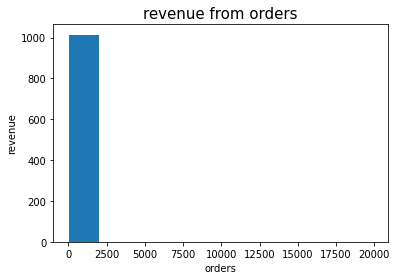

In [44]:
plt.hist(orders['revenue'])
plt.title('revenue from orders', fontsize=15)
plt.xlabel('orders')
plt.ylabel('revenue')
plt.show()

looks good, check on scatterplot

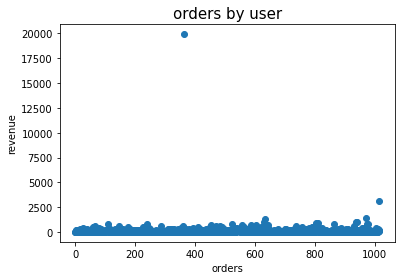

In [45]:
x_values = pd.Series(range(0, len(orders)))
plt.scatter(x_values, orders['revenue'])
plt.title('orders by user', fontsize=15)
plt.xlabel('orders')
plt.ylabel('revenue')
plt.show()

* we see the bulk below 2500 and even below, but it is impossible to say how much
* two points with abnormally high data at 2500 and 20000 - this is a lot
* in principle, it seems to me that there is a problem with the retention of clients and it is worth thinking about it.

# 8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [46]:
print('percentiles: 90%, 95%, 99%:', np.percentile(orders['revenue'], [90, 95, 99]))

percentiles: 90%, 95%, 99%: [280.8   414.275 830.3  ]


* 90% of users order less than 281
* 5% of orders between 281 and 414
* only 1% of orders over 830
* this confirms our conclusion from the previous step

# 9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

my first hypothesis would be:
1. there is no difference between the difference in conversions of groups A and B.
2. to test the hypothesis, we will do the following calculations
3. if it turns out that we are right, then the hypothesis is accepted, if not, then it is rejected

In [47]:
alpha = 0.05
orders_by_user_a = orders[orders['group'] == 'A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
orders_by_user_a.columns = ['visitor_id', 'transaction_id']
orders_by_user_b = orders[orders['group'] == 'B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
orders_by_user_b.columns = ['visitor_id', 'transaction_id']


In [48]:
orders_by_user_a.head()


,visitor_id,transaction_id
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [49]:
orders_by_user_b.head()

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [50]:
sample_a = pd.concat([orders_by_user_a['transaction_id'],
                      pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - 
                                                                                      len(orders_by_user_a['transaction_id'])),name='transaction_id')],axis=0)
sample_b = pd.concat([orders_by_user_b['transaction_id'],
                      pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - 
                                                                                      len(orders_by_user_a['transaction_id'])),name='transaction_id')],axis=0)


print('Relative gaine:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

result = st.mannwhitneyu(sample_a, sample_b)[1]

print('p-value: ', "{0:.3f}".format(result))

if (result < alpha):
    print('We can reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

Relative gaine: 0.155
p-value:  0.013
We can reject the null hypothesis


* based on raw data, we see a difference between groups A and B and therefore our null hypothesis that they are equal is not true
* our pi value is 0.013, which is less than alpha and means there is no statistically significant between groups

# 10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

tested hypothesis:
- there is a difference in the average order size of groups A and B

In [51]:

print('significance of the difference:', "{0:.3f}".format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

result = st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'].mean(), orders[orders['group'] == 'B']['revenue'].mean())[1]

print('p-value: ', "{0:.3f}".format(result))

if (result < alpha):
    print('We can reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

significance of the difference: 0.278
p-value:  1.000
We can't reject the null hypothesis


In [52]:
print('Group A orders revenue mean:', "{:.3f}".format(orders_a['revenue'].mean()))
print('Group B orders revenue mean:', "{:.3f}".format(orders_b['revenue'].mean()))

Group A orders revenue mean: 115.897
Group B orders revenue mean: 145.063


* the p-value is much bigger than alpha, and no reason to reject the null hypothesis and conclud that average order size is differs between the groups
* but the average order size of group B is bigger then A 

# 11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

first we see how many users witn anomaly behaviour


In [53]:
multy_order_users = pd.concat([orders_by_user_a[orders_by_user_a['transaction_id'] > 1]['visitor_id'], 
                              orders_by_user_b[orders_by_user_b['transaction_id'] > 1]['visitor_id']], axis = 0)
big_order_users = orders[orders['revenue'] > 414.275]['visitorid']
abnormal_users = pd.concat([multy_order_users , big_order_users], axis = 0).drop_duplicates().sort_values()
abnormal_users.head()

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64

In [54]:
abnormal_users.shape

(86,)

86 abnormal results, that's quite a lot, and they certainly affect the results of the test.
Let's try to look at the results without these anomalies. 
- And test the hypothesis that there is a difference in conversion between groups A and B based on the filtered data

In [55]:
sample_a_filter = pd.concat([orders_by_user_a[np.logical_not(orders_by_user_a['visitor_id'].isin(abnormal_users))]['transaction_id'],
                      pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - len(orders_by_user_a['transaction_id'])),
                               name = 'transaction_id')], axis = 0)
sample_b_filter = pd.concat([orders_by_user_b[np.logical_not(orders_by_user_b['visitor_id'].isin(abnormal_users))]['transaction_id'],
                      pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - len(orders_by_user_b['transaction_id'])),
                               name = 'transaction_id')], axis = 0)


print('Relative gaine:', "{0:.3f}".format(sample_b_filter.mean() / sample_a_filter.mean() - 1))

result = st.mannwhitneyu(sample_a_filter, sample_b_filter)[1]

print('p-value: ', "{0:.3f}".format(result))

if (result < alpha):
    print('We can reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

Relative gaine: 0.174
p-value:  0.016
We can reject the null hypothesis


old results:
Relative gaine: 0.155
p-value:  0.013
* we see that we have the same result. p-value is smaller than alpha and we can reject  hypothesis that groups has difference result between them.

# 12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

tested hypothesis:
- there is a difference in the average order size of groups A and B, based on filtered data

In [56]:
print('significance of the difference:', "{0:.3f}".format(
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean() /
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean() - 1))

result = st.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'])[1]

print('p-value:', "{0:.3f}".format(result))  
    
if (result < alpha):
    print('We can reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

significance of the difference: -0.033
p-value: 0.771
We can't reject the null hypothesis


results from step 10
significance of the difference: 0.278
p-value:  1.000
We can't reject the null hypothesis
* we can't reject the null hypothesis jast like in step 10, and at first sight we have the same result.
* but here we have significance of the difference: -0.033,I think the point is that when we work with the filtered data, we see that the mean order size of group B is smaller than group A. We didn't see this in step 10 because there was quite a lot of anomalous data.
* we now see that even though we cannot reject the theory, we know that group A actually performs better than group B.

# 13. Make a decision based on the test results. The possible decisions are: 
* Stop the test, consider one of the groups the leader. 
* Stop the test, conclude that there is no difference between the groups. 
* Continue the test.

1. from our graphs we see that group B has better cum revenue by group and date. and better cum maen order size. but both depend of outliers. It seems that group B has better conversion rate
2. We see that every user that make more then 1 order and  with revenue more then 415 is anomaly user.
3. then we did some tests on raw data and see that there is a difference in conversion between groups and relative gane is positive for group B
4. we made tests for significance of the difference in average order size using the raw data and find that we have no reason to to reject our hypothesis and conclude that there are some differs between the groups. But we still have big picks on group B.
5. we find 86 outliers and make filtred data
6. based on this data we see that the results didn't change
7. For the difference in average order size between the groups using the filtered p value increased abit but this didn't change much, though now it looks like the average order size of B is just abit smaller then for A if we leave aside our outliers. this might mean that without outliers our graph for average order sized might have stabilized more now. still in general seems like B is leading.
8. From the graphs and tests we could see the model had pretty much stabalised (after taking care of anomalies) and we can say we should stop the test and from the graphs and tests we could see the model had pretty much stabalised (after taking care of anomalies) and we can say we should stop the test and announce B as the winner!

This is the results of our campaign and we know our test is a success and we can advise our company what to do.

# General conclusion

1. In the first part of our project, we researched ICE and RICE frameworks and came to the conclusion that RICE is the best for our project. this is what we will use
2. In the second part, we examined various hypotheses and came to the conclusion that
* you can stop the test, because. we have chosen the winner
* group B performed better than group A